In [9]:
!pip install rdp
!pip install svgwrite

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.interpolate import splprep, splev
from shapely.geometry import Polygon, MultiPolygon, GeometryCollection
from shapely.ops import unary_union
from shapely.validation import make_valid
from rdp import rdp
import svgwrite
import csv


def parse_data_file(file_path):
    '''Converts CSV data to a structured form.'''
    raw_data = np.genfromtxt(file_path, delimiter=',')
    structured_data = []

    # Iterate over each unique group ID in the data
    for group_id in np.unique(raw_data[:, 0]):
        # Select rows belonging to the current group ID
        group_data = raw_data[raw_data[:, 0] == group_id][:, 1:]
        subgroups = []

        # Iterate over each unique subgroup ID within the current group
        for subgroup_id in np.unique(group_data[:, 0]):
            # Select rows belonging to the current subgroup ID
            subgroup = group_data[group_data[:, 0] == subgroup_id][:, 1:]
            subgroups.append(subgroup)
        structured_data.append(subgroups)
    return structured_data

def optimize_data_points(data, epsilon=1.0):
    '''Applies the Ramer-Douglas-Peucker (RDP) algorithm to simplify the data points.'''
    optimized_data = []

    for group in data:
        optimized_group = []

        for subgroup in group:
            # Apply the RDP algorithm if the subgroup has more than 2 points
            if len(subgroup) > 2:
                optimized_subgroup = rdp(subgroup, epsilon=epsilon)
                optimized_group.append(optimized_subgroup)
            else:
                optimized_group.append(subgroup)

        # Add the optimized group to the optimized data
        optimized_data.append(optimized_group)
    return optimized_data

def complete_shapes(data):
    '''Completes shapes by generating convex hulls for each subgroup of points.'''
    completed_data = []

    for group in data:
        completed_group = []
        for subgroup in group:
            # Generate the convex hull if the subgroup has more than 2 points
            if len(subgroup) > 2:
                hull = ConvexHull(subgroup)
                completed_subgroup = subgroup[hull.vertices]
            else:
                completed_subgroup = subgroup

            completed_group.append(completed_subgroup)

        completed_data.append(completed_group)
    return completed_data

def generate_smooth_curve(points, resolution=1000):
    '''Performs spline interpolation to connect separate regions with a smooth curve.'''
    if len(points) < 2:
        return points

    # Generate the spline representation of the curve
    tck, u = splprep([points[:, 0], points[:, 1]], s=0)

    # Create a fine sampling of the parameter space
    u_fine = np.linspace(0, 1, resolution)

    # Evaluate the spline at the fine sampling points
    x_fine, y_fine = splev(u_fine, tck)

    # Return the smooth curve as an array of x, y points
    return np.vstack((x_fine, y_fine)).T

def visualize_data(data, color_scheme):
    '''Plots the occlusions and smooth curves for visualization.'''
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

    for i, group in enumerate(data):
        color = color_scheme[i % len(color_scheme)]

        for subgroup in group:
            if len(subgroup) > 2:
                smooth_curve = generate_smooth_curve(subgroup)
                ax.plot(smooth_curve[:, 0], smooth_curve[:, 1], c=color, linewidth=2)
                ax.fill(smooth_curve[:, 0], smooth_curve[:, 1], c=color, alpha=0.3)
            else:
                ax.plot(subgroup[:, 0], subgroup[:, 1], c=color, linewidth=2)
                ax.fill(subgroup[:, 0], subgroup[:, 1], c=color, alpha=0.3)

    ax.set_aspect('equal')
    plt.show()

def check_connectivity(data):
    '''Checks whether the provided shapes form a unified or separate connected component.'''
    polygons = []

    for group in data:
        for subgroup in group:
            if len(subgroup) > 2:
                # Create a polygon from the subgroup
                poly = Polygon(subgroup)

                if poly.is_valid:
                    # Add the valid polygon to the list
                    polygons.append(poly)
                else:
                    # Fix and add the invalid polygon to the list
                    fixed_poly = make_valid(poly)
                    polygons.append(fixed_poly)

    if not polygons:
        return "Separate"

    try:
        # Create a MultiPolygon from the list of polygons
        multi_poly = MultiPolygon(polygons)

        # Perform a unary union operation to merge polygons
        unified_poly = unary_union(multi_poly)

        if isinstance(unified_poly, Polygon):
            return "United"
        elif isinstance(unified_poly, MultiPolygon):
            return "United" if len(unified_poly.geoms) == 1 else "Separate"
        elif isinstance(unified_poly, GeometryCollection):
            # Filter and check valid polygons in a GeometryCollection
            valid_polys = [geom for geom in unified_poly.geoms if isinstance(geom, Polygon) and geom.is_valid]
            if valid_polys:
                multi_poly = MultiPolygon(valid_polys)
                return "United" if len(multi_poly.geoms) == 1 else "Separate"
            else:
                return "Separate"
    except Exception as e:
        print(f"Error in connectivity check: {e}")
        return "Separate"

def process_and_complete_data(input_file, color_scheme):
    '''Processes the input data and attempts to complete shapes if needed.'''
    input_data = parse_data_file(input_file)

    # Optimize the data points using the RDP algorithm
    optimized_data = optimize_data_points(input_data, epsilon=1.0)

    visualize_data(optimized_data, color_scheme)
    print()
    print()

    # Check the connectivity of the input data
    input_status = check_connectivity(optimized_data)

    # Attempt to complete shapes and visualize the result
    completed_data = complete_shapes(optimized_data)
    visualize_data(completed_data, color_scheme)
    print()
    print()

    # Check the connectivity of the completed data
    output_status = check_connectivity(completed_data)

def export_to_csv(data, filename):
    '''Exports the processed data to a CSV file with specific formatting.'''
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([0, 0, 0, "x", "y"])  # Write the header

        for group in data:
            for subgroup in group:
                for x, y in subgroup:
                    writer.writerow([0, 0, 0, x, y])

Visualizing input data...


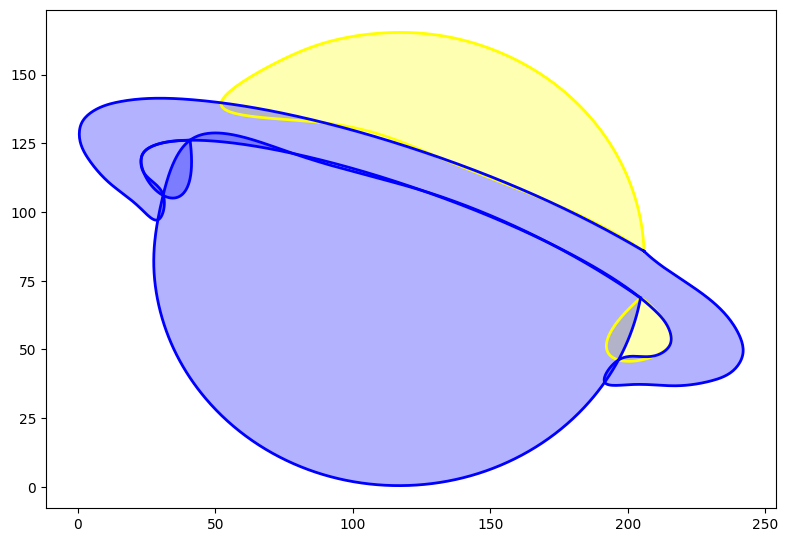

Error in connectivity check: 'MultiPolygon' object is not subscriptable
Visualizing completed data...


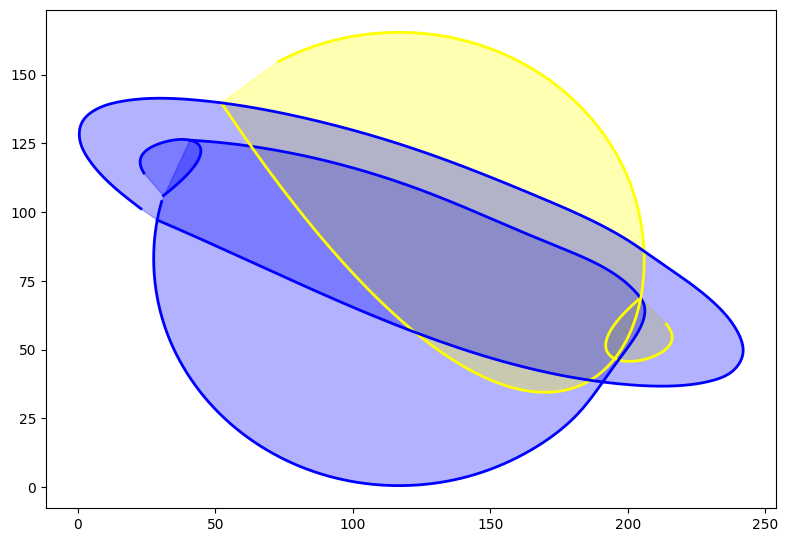

Input status: Separate
Output status: United
Shapes have been completed


In [11]:
input_file = 'occlusion2.csv'
color_scheme = ['blue', 'yellow']

# Main processing function
process_and_complete_data(input_file, color_scheme)

# If you want to create an SVG of the simplified paths
raw_data = parse_data_file(input_file)
optimized_data = optimize_data_points(raw_data)
export_to_csv(optimized_data, 'output_completion.csv')